In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from numpy import where
from numpy import meshgrid
from numpy import arange
from numpy import hstack
from numpy import std
from numpy import mean

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.simplefilter('ignore')

# Function for Further Uses

In [151]:
# Calculate the metrics
def calculate_metrics(df, method, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 16})
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    auc = np.NAN
    #auc = roc_auc_score(y_test, y_pred, multi_class="ovr", average='macro')
    df.loc[method] = [accuracy, precision, recall, f1, auc]
    #df.loc[method] = [accuracy, precision, recall, f1]

In [153]:
# Do the the cross validation of all metrics
def calculate_cv(df, classifier, method, X, y):
    accuracy = eval_cv(classifier, 'accuracy', X, y)
    precision = eval_cv(classifier, 'precision', X, y)
    recall = eval_cv(classifier, 'recall', X, y)
    f1 = eval_cv(classifier, 'f1', X, y)
    auc = eval_cv(classifier, 'roc_auc', X, y)
    df.loc[method] = [accuracy, precision, recall, f1, auc]

In [154]:
# Calulate metrics using cross validation
def calculate_cv(df, classifier, method, X, y):
    # Define Kfold cross validator with number of split =5
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    i = 1
    
    # Dataframe to track the accuracy accross the splitted dataset
    df_eval = pd.DataFrame(columns = ['iter', 'acc'])
    
    accuracies = []
    precisions = [] 
    recalls = []
    f1s = []
    aucs = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        # train the model with training data
        classifier.fit(X_train, y_train)
        # predict with testing data 
        y_pred = classifier.predict(X_test)
    

        # evaluate the model on testing data
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average='macro'))
        recalls.append(recall_score(y_test, y_pred,  average='macro'))  
        f1s.append(f1_score(y_test, y_pred,  average='macro'))
        #aucs.append(roc_auc_score(y_test, y_pred,  average='macro', multi_class='ovr'))
            
        # fill out the tracking dataframe with accuracy score
        new_row = {'iter': i, 'acc':accuracy_score(y_test, y_pred)}
        df_eval = df_eval.append(new_row, ignore_index=True)
            
        # get the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        fig = px.imshow(cm)
        fig.show()
        i+=1
            
            
    # calculate the average of each metric
    accuracy = sum(accuracies) / len(accuracies)
    precision = sum(precisions) / len(precisions)
    recall = sum(recalls) / len(recalls)
    f1 = sum(f1s) / len(f1s)
    # Disable AUC ROC for multiclass
    #auc = sum(aucs) / len(aucs)
    auc = np.NaN
        
    # display the bar chart for the accuracy tracking
    fig = px.bar(df_eval, x='iter', y='acc')
    fig.show()
        
    df.loc[method] = [accuracy, precision, recall, f1, auc]

In [155]:
# Evaluation using cross validation
def eval_cv(classifier, metric, X, y):
    kf = KFold(n_splits=5)
    
    scoring = make_scorer(metric, average = 'micro')
    # evaluate model
    scores = cross_val_score(classifier, X, y, scoring=scoring, cv=kf, n_jobs=-1)
    # report performance
    return mean(scores)

# Load the Dataset

In [156]:
df = pd.read_csv(r'SaYoPillow.csv')
df

,sr,rr,t,lm,bo,rem,sr.1,hr,sl
0,93.800,25.680,91.840,16.600,89.840,99.60,1.840,74.20,3
1,91.640,25.104,91.552,15.880,89.552,98.88,1.552,72.76,3
2,60.000,20.000,96.000,10.000,95.000,85.00,7.000,60.00,1
3,85.760,23.536,90.768,13.920,88.768,96.92,0.768,68.84,3
4,48.120,17.248,97.872,6.496,96.248,72.48,8.248,53.12,0
...,...,...,...,...,...,...,...,...,...
625,69.600,20.960,92.960,10.960,90.960,89.80,3.440,62.40,2
626,48.440,17.376,98.064,6.752,96.376,73.76,8.376,53.44,0
627,97.504,27.504,86.880,17.752,84.256,101.88,0.000,78.76,4
628,58.640,19.728,95.728,9.728,94.592,84.32,6.728,59.32,1


# Dataset Description

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sr      630 non-null    float64
 1   rr      630 non-null    float64
 2   t       630 non-null    float64
 3   lm      630 non-null    float64
 4   bo      630 non-null    float64
 5   rem     630 non-null    float64
 6   sr.1    630 non-null    float64
 7   hr      630 non-null    float64
 8   sl      630 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 44.4 KB


In [158]:
#Find missing values
percent_missing = dataset.isnull().sum() * 100 / len(dataset)
missing_value_df = pd.DataFrame({'column_name': dataset.columns,
                                 'percent_missing': percent_missing})
display(missing_value_df)

,column_name,percent_missing
sr,sr,0.0
rr,rr,0.0
t,t,0.0
lm,lm,0.0
bo,bo,0.0
rem,rem,0.0
sr.1,sr.1,0.0
hr,hr,0.0
sl,sl,0.0


# Exploratory Data Analysis

In [159]:
#get basic statistical features
df.describe()

,sr,rr,t,lm,bo,rem,sr.1,hr,sl
count,630.000000,630.000000,630.00000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000
mean,71.600000,21.800000,92.80000,11.700000,90.900000,88.500000,3.700000,64.500000,2.000000
std,19.372833,3.966111,3.52969,4.299629,3.902483,11.893747,3.054572,9.915277,1.415337
min,45.000000,16.000000,85.00000,4.000000,82.000000,60.000000,0.000000,50.000000,0.000000
25%,52.500000,18.500000,90.50000,8.500000,88.500000,81.250000,0.500000,56.250000,1.000000
50%,70.000000,21.000000,93.00000,11.000000,91.000000,90.000000,3.500000,62.500000,2.000000
75%,91.250000,25.000000,95.50000,15.750000,94.250000,98.750000,6.500000,72.500000,3.000000
max,100.000000,30.000000,99.00000,19.000000,97.000000,105.000000,9.000000,85.000000,4.000000


<Figure size 720x720 with 0 Axes>

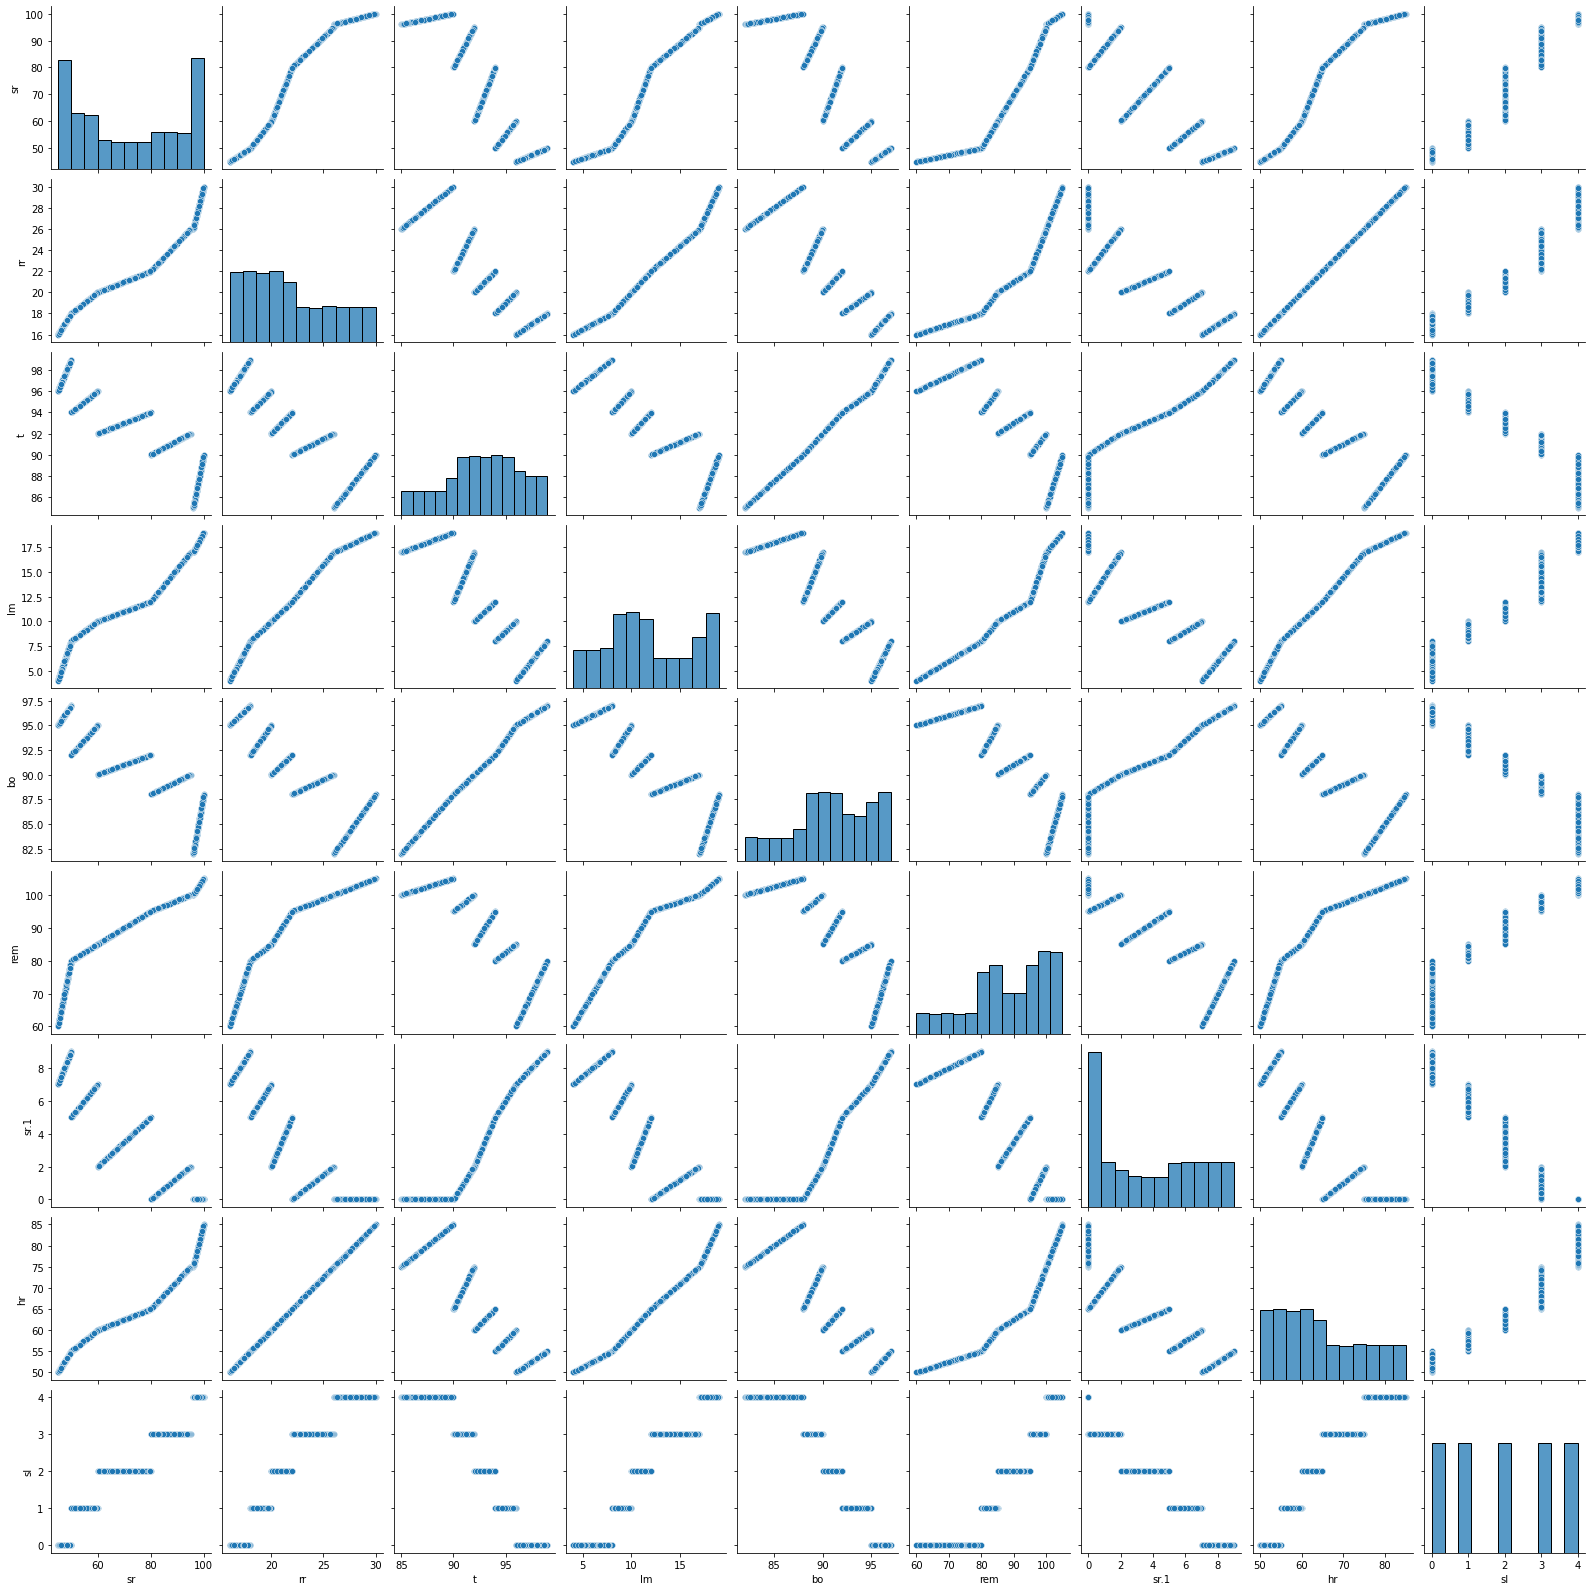

In [160]:
#pair plot using seaborn
plt.figure(figsize=(10, 10))
sns.pairplot(df)
plt.show()

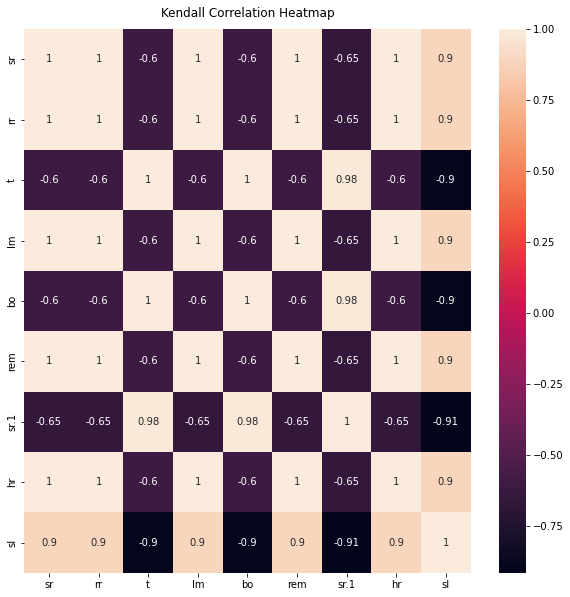

In [161]:
#corelation heatmap using seaborn
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(dataset.corr(method='kendall'), annot=True)
heatmap.set_title('Kendall Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

# Splitting the Data


In [162]:
# Get X (independent variables) and y (dependent variable)
y_label = 'sl'
X = dataset.loc[:, dataset.columns != y_label]
display(pd.DataFrame(X))
y = dataset.loc[:, y_label]
display(pd.DataFrame(y))

,sr,rr,t,lm,bo,rem,sr.1,hr
0,93.800,25.680,91.840,16.600,89.840,99.60,1.840,74.20
1,91.640,25.104,91.552,15.880,89.552,98.88,1.552,72.76
2,60.000,20.000,96.000,10.000,95.000,85.00,7.000,60.00
3,85.760,23.536,90.768,13.920,88.768,96.92,0.768,68.84
4,48.120,17.248,97.872,6.496,96.248,72.48,8.248,53.12
...,...,...,...,...,...,...,...,...
625,69.600,20.960,92.960,10.960,90.960,89.80,3.440,62.40
626,48.440,17.376,98.064,6.752,96.376,73.76,8.376,53.44
627,97.504,27.504,86.880,17.752,84.256,101.88,0.000,78.76
628,58.640,19.728,95.728,9.728,94.592,84.32,6.728,59.32


,sl
0,3
1,3
2,1
3,3
4,0
...,...
625,2
626,0
627,4
628,1


In [163]:
my_test_size = 0.25
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=my_test_size, shuffle=False)
X_train.describe()

,sr,rr,t,lm,bo,rem,sr.1,hr
count,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000
mean,71.718949,21.813966,92.753424,11.729102,90.843441,88.611271,3.686390,64.534915
std,19.338649,3.937417,3.564388,4.275457,3.941467,11.798882,3.047055,9.843543
min,45.000000,16.000000,85.000000,4.000000,82.000000,60.000000,0.000000,50.000000
25%,52.540000,18.508000,90.524000,8.508000,88.524000,81.270000,0.524000,56.270000
50%,70.640000,21.064000,93.032000,11.064000,91.032000,90.320000,3.548000,62.660000
75%,91.190000,24.984000,95.428000,15.730000,94.142000,98.730000,6.428000,72.460000
max,100.000000,30.000000,99.000000,19.000000,97.000000,105.000000,9.000000,85.000000


In [164]:
#Feature standardizing of X
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [165]:
#Get the original X_test
X_test_orig = sc_X.inverse_transform(X_test)
display(pd.DataFrame(X_test_orig))

,0,1,2,3,4,5,6,7
0,94.160,25.776,91.888,16.720,89.888,99.72,1.888000e+00,74.44
1,51.760,18.352,94.352,8.352,92.528,80.88,5.352000e+00,55.88
2,45.920,16.368,96.552,4.736,95.368,63.68,7.368000e+00,50.92
3,91.040,24.944,91.472,15.680,89.472,98.68,1.472000e+00,72.36
4,54.800,18.960,94.960,8.960,93.440,82.40,5.960000e+00,57.40
...,...,...,...,...,...,...,...,...
153,69.600,20.960,92.960,10.960,90.960,89.80,3.440000e+00,62.40
154,48.440,17.376,98.064,6.752,96.376,73.76,8.376000e+00,53.44
155,97.504,27.504,86.880,17.752,84.256,101.88,-4.440892e-16,78.76
156,58.640,19.728,95.728,9.728,94.592,84.32,6.728000e+00,59.32


# Create Dataframes for Evaluation

In [166]:
# included methods/models and metrics
methods = ['Logistic Regression', 'KNN', 'Linear SVM', 'Kernel SVM', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 score', 'ROC AUC']
#metrics = ['Accuracy', 'Precision', 'Recall', 'F1 score']

# create model quality dataframe
quality_df = pd.DataFrame(columns = metrics, index = methods)
display(quality_df)

# create model quality cross validation dataframe
quality_cv_df = pd.DataFrame(columns = metrics, index = methods)
display(quality_cv_df)

,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,NaN,NaN,NaN,NaN,NaN
KNN,NaN,NaN,NaN,NaN,NaN
Linear SVM,NaN,NaN,NaN,NaN,NaN
Kernel SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,NaN,NaN,NaN,NaN,NaN
KNN,NaN,NaN,NaN,NaN,NaN
Linear SVM,NaN,NaN,NaN,NaN,NaN
Kernel SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


## Logistic Regression

In [167]:
# Fit the model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [168]:
#Predicting test set result
y_pred = classifier.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,3
1,1
2,0
3,3
4,1
...,...
153,2
154,0
155,4
156,1


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,NaN
KNN,NaN,NaN,NaN,NaN,NaN
Linear SVM,NaN,NaN,NaN,NaN,NaN
Kernel SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,NaN
KNN,NaN,NaN,NaN,NaN,NaN
Linear SVM,NaN,NaN,NaN,NaN,NaN
Kernel SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


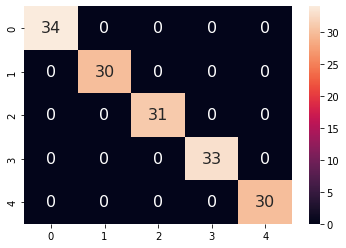

In [169]:
# Evaluate the model
method = 'Logistic Regression'
calculate_metrics(quality_df, method, y_test, y_pred)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method, X, y)
display(quality_cv_df)

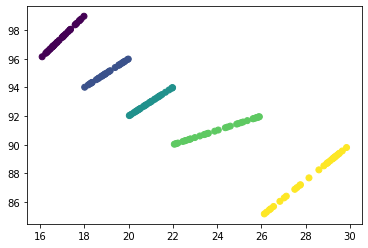

In [170]:
plt.scatter(X_test_orig[:,1],X_test_orig[:,2],c=y_pred)
plt.show()

## KNN

In [171]:
# Fit the model
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 40, metric = 'euclidean')
classifier.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=40)

In [172]:
#Predicting test set result
y_pred = classifier.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,3
1,1
2,0
3,3
4,1
...,...
153,2
154,0
155,4
156,1


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,NaN
KNN,1.0,1.0,1.0,1.0,NaN
Linear SVM,NaN,NaN,NaN,NaN,NaN
Kernel SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,NaN
KNN,1.0,1.0,1.0,1.0,NaN
Linear SVM,NaN,NaN,NaN,NaN,NaN
Kernel SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


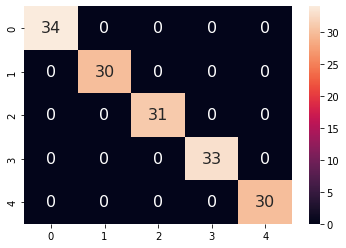

In [173]:
# Evaluate the model
method = 'KNN'
calculate_metrics(quality_df, method, y_test, y_pred)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method, X, y)
display(quality_cv_df)

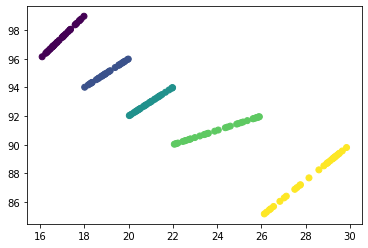

In [174]:
plt.scatter(X_test_orig[:,1],X_test_orig[:,2],c=y_pred)
plt.show()

## Linear SVM

In [175]:
# Fit the model
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear')
classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [176]:
#Predicting test set 
y_pred = classifier.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,3
1,1
2,0
3,3
4,1
...,...
153,2
154,0
155,4
156,1


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,NaN
KNN,1.0,1.0,1.0,1.0,NaN
Linear SVM,1.0,1.0,1.0,1.0,NaN
Kernel SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,NaN
KNN,1.0,1.0,1.0,1.0,NaN
Linear SVM,1.0,1.0,1.0,1.0,NaN
Kernel SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


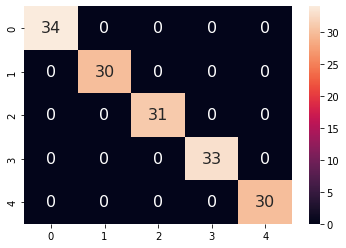

In [177]:
# Evaluate the model
method = 'Linear SVM'
calculate_metrics(quality_df, method, y_test, y_pred)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method, X, y)
display(quality_cv_df)

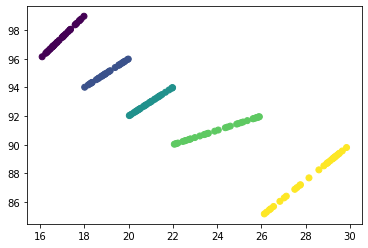

In [178]:
plt.scatter(X_test_orig[:,1],X_test_orig[:,2],c=y_pred)
plt.show()

## Kernel SVM

In [179]:
# Fit the model
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf')
classifier.fit(X_train, y_train)

SVC()

In [180]:
#Predict the test set 
y_pred = classifier.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,3
1,1
2,0
3,3
4,1
...,...
153,2
154,0
155,4
156,1


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,NaN
KNN,1.0,1.0,1.0,1.0,NaN
Linear SVM,1.0,1.0,1.0,1.0,NaN
Kernel SVM,1.0,1.0,1.0,1.0,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,NaN
KNN,1.0,1.0,1.0,1.0,NaN
Linear SVM,1.0,1.0,1.0,1.0,NaN
Kernel SVM,0.995238,0.994451,0.995541,0.994838,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


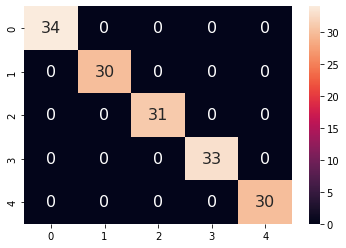

In [181]:
# Evaluate the model
method = 'Kernel SVM'
calculate_metrics(quality_df, method, y_test, y_pred)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method, X, y)
display(quality_cv_df)

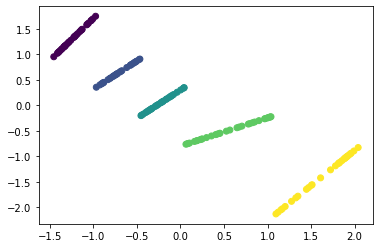

In [182]:
plt.scatter(X_test[:,1],X_test[:,2],c=y_pred)
plt.show()

## Naive Bayes

In [183]:
# Fit the model
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [184]:
#Predict the test set 
y_pred = classifier.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,3
1,1
2,0
3,3
4,1
...,...
153,2
154,0
155,4
156,1


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,NaN
KNN,1.0,1.0,1.0,1.0,NaN
Linear SVM,1.0,1.0,1.0,1.0,NaN
Kernel SVM,1.0,1.0,1.0,1.0,NaN
Naive Bayes,1.0,1.0,1.0,1.0,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,NaN
KNN,1.0,1.0,1.0,1.0,NaN
Linear SVM,1.0,1.0,1.0,1.0,NaN
Kernel SVM,0.995238,0.994451,0.995541,0.994838,NaN
Naive Bayes,1.0,1.0,1.0,1.0,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


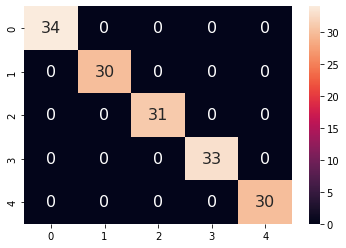

In [185]:
# Evaluate the model
method = 'Naive Bayes'
calculate_metrics(quality_df, method, y_test, y_pred)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method, X, y)
display(quality_cv_df)

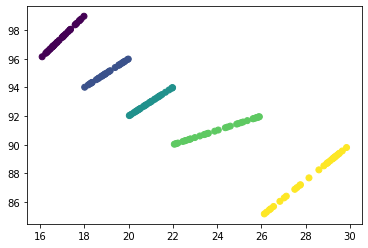

In [186]:
plt.scatter(X_test_orig[:,1],X_test_orig[:,2],c=y_pred)
plt.show()

## Decision tree

In [187]:
# Fit the model
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'gini', random_state = 0, min_samples_split = 10)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_split=10, random_state=0)

In [188]:
#Predict the test set 
y_pred = classifier.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,3
1,1
2,0
3,3
4,1
...,...
153,2
154,0
155,4
156,1


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,NaN
KNN,1.0,1.0,1.0,1.0,NaN
Linear SVM,1.0,1.0,1.0,1.0,NaN
Kernel SVM,1.0,1.0,1.0,1.0,NaN
Naive Bayes,1.0,1.0,1.0,1.0,NaN
Decision Tree,0.993671,0.994118,0.993548,0.993736,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,NaN
KNN,1.0,1.0,1.0,1.0,NaN
Linear SVM,1.0,1.0,1.0,1.0,NaN
Kernel SVM,0.995238,0.994451,0.995541,0.994838,NaN
Naive Bayes,1.0,1.0,1.0,1.0,NaN
Decision Tree,0.987302,0.987422,0.987616,0.987324,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


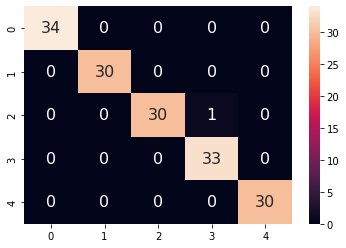

In [189]:
# Evaluate the model
method = 'Decision Tree'
calculate_metrics(quality_df, method, y_test, y_pred)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method, X, y)
display(quality_cv_df)

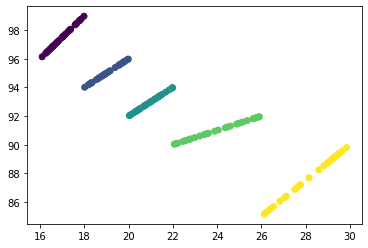

In [190]:
plt.scatter(X_test_orig[:,1],X_test_orig[:,2],c=y_pred)
plt.show()

## Random Forest

In [191]:
# Fit the model
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, oob_score=True, criterion = 'gini', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=0)

In [192]:
#Predict the test set 
y_pred = classifier.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,3
1,1
2,0
3,3
4,1
...,...
153,2
154,0
155,4
156,1


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,NaN
KNN,1.0,1.0,1.0,1.0,NaN
Linear SVM,1.0,1.0,1.0,1.0,NaN
Kernel SVM,1.0,1.0,1.0,1.0,NaN
Naive Bayes,1.0,1.0,1.0,1.0,NaN
Decision Tree,0.993671,0.994118,0.993548,0.993736,NaN
Random Forest,1.0,1.0,1.0,1.0,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,NaN
KNN,1.0,1.0,1.0,1.0,NaN
Linear SVM,1.0,1.0,1.0,1.0,NaN
Kernel SVM,0.995238,0.994451,0.995541,0.994838,NaN
Naive Bayes,1.0,1.0,1.0,1.0,NaN
Decision Tree,0.987302,0.987422,0.987616,0.987324,NaN
Random Forest,0.990476,0.990618,0.990159,0.990188,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN


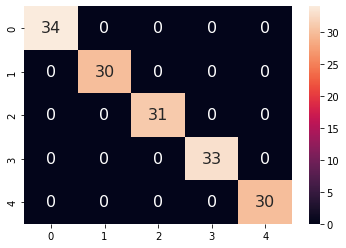

In [193]:
# Evaluate the model
method = 'Random Forest'
calculate_metrics(quality_df, method, y_test, y_pred)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method, X, y)
display(quality_cv_df)

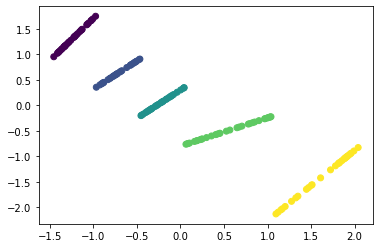

In [194]:
plt.scatter(X_test[:,1],X_test[:,2],c=y_pred)
plt.show()

## XGBoost

In [195]:
# Fit the model
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [196]:
#Predict the test set 
y_pred = classifier.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,3
1,1
2,0
3,3
4,1
...,...
153,2
154,0
155,4
156,1


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,NaN
KNN,1.0,1.0,1.0,1.0,NaN
Linear SVM,1.0,1.0,1.0,1.0,NaN
Kernel SVM,1.0,1.0,1.0,1.0,NaN
Naive Bayes,1.0,1.0,1.0,1.0,NaN
Decision Tree,0.993671,0.994118,0.993548,0.993736,NaN
Random Forest,1.0,1.0,1.0,1.0,NaN
XGBoost,1.0,1.0,1.0,1.0,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,1.0,1.0,1.0,1.0,NaN
KNN,1.0,1.0,1.0,1.0,NaN
Linear SVM,1.0,1.0,1.0,1.0,NaN
Kernel SVM,0.995238,0.994451,0.995541,0.994838,NaN
Naive Bayes,1.0,1.0,1.0,1.0,NaN
Decision Tree,0.987302,0.987422,0.987616,0.987324,NaN
Random Forest,0.990476,0.990618,0.990159,0.990188,NaN
XGBoost,0.988889,0.989869,0.988342,0.988878,NaN


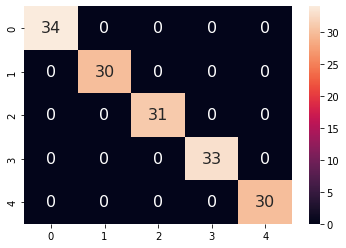

In [197]:
# Evaluate the model
method = 'XGBoost'
calculate_metrics(quality_df, method, y_test, y_pred)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method, X, y)
display(quality_cv_df)